In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [2]:
import numpy as np
from tensorflow.keras.datasets import mnist
import warnings

# Suppress all Python warnings
warnings.filterwarnings('ignore')

# Load the MNIST dataset
(X_train, _), (_, _) = mnist.load_data()

# Normalize the pixel values to the range [-1, 1]
X_train = X_train.astype('float32') / 127.5 - 1.
X_train = np.expand_dims(X_train, axis=-1)

# Print the shape of the data
print(X_train.shape)

(60000, 28, 28, 1)


### Building the generator model

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape

def build_generator():
    model = Sequential()
    model.add(Dense(256, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(28 * 28 * 1, activation='tanh'))
    model.add(Reshape((28, 28, 1)))
    return model

# Build the generator
generator_ = build_generator()
generator_.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 784)            │       803,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,493,520 (5.70 MB)

 Trainable params: 1,489,936 (5.68 MB)

 Non-trainable params: 3,584 (14.00 KB)

### Building the discriminator model

In [5]:
from tensorflow.keras.layers import Flatten

# Define the discriminator model
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28, 1)))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Build and compile tje discriminator
discriminator_ = build_discriminator()
discriminator_.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
discriminator_.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,505 (2.04 MB)

 Trainable params: 533,505 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

# Create the GAN by stacking the generator and the discriminator
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(100,))
    generated_image = generator(gan_input)
    gan_output = discriminator(generated_image)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

# Build the GAN
gan = build_gan(generator_, discriminator_)
gan.summary()

Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 28, 28, 1)      │     1,493,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 1)              │       533,505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,027,025 (7.73 MB)

 Trainable params: 1,489,936 (5.68 MB)

 Non-trainable params: 537,089 (2.05 MB)

In [8]:
# Sync discriminator weights from trainable to non-trainable in GAN
gan.layers[2].set_weights(discriminator_.get_weights())

In [15]:
batch_size = 64
epochs = 200
sample_interval = 10

real = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for epoch_ in range(epochs):
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_images = X_train[idx]
    noise = np.random.normal(0, 1, (batch_size, 100))
    generated_images = generator_.predict(noise)
    d_loss_real = discriminator_.train_on_batch(real_images, real)
    d_loss_fake = discriminator_.train_on_batch(generated_images, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator
    noise = np.random.normal(0, 1, (batch_size, 100))
    g_loss = gan.train_on_batch(noise, real)

    # Print the process
    if epoch_ % sample_interval == 0:
        print(f"{epoch_} [D Loss: {d_loss[0]}] [D Accuracy: {100 * d_loss[1]:.2}%] [G Loss: {g_loss}]")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
0 [D Loss: 1.1628696918487549] [D Accuracy: 10.199175834655762%] [G Loss: 0.38232073187828064]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
10 [D Loss: 1.7344385385513306] [D Accuracy: 4.2453484535217285%] [G Loss: 0.19299213588237762]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
20 [D Loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


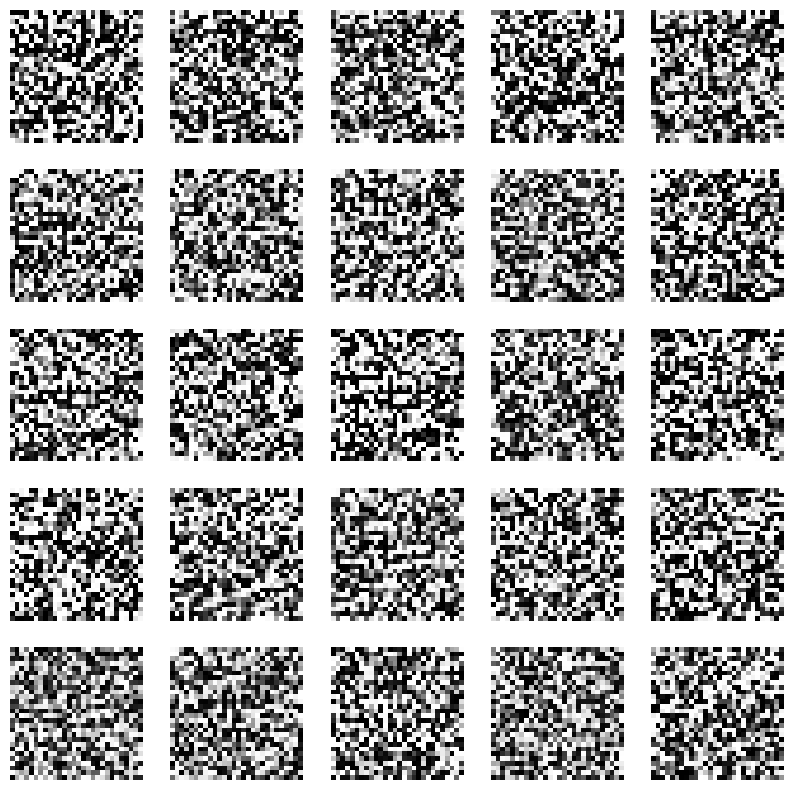

In [16]:
import matplotlib.pyplot as plt

def sample_images(generator, num_images=25):
    noise_ = np.random.normal(0, 1, (num_images, 100))
    generated_images_ = generator.predict(noise_)
    generated_images_ = .5 * generated_images_ + 0.5 # Rescale to [0, 1]
    fig, axs = plt.subplots(5, 5, figsize=(10, 10))
    count = 0

    for i in range(5):
        for j in range(5):
            axs[i, j].imshow(generated_images_[count, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            count += 1
    plt.show()

# Sample images at the end of training
sample_images(generator_)

In [17]:
# Calculate and print the discriminator accuracy on real vs. fake images
noise = np.random.normal(0, 1, (batch_size, 100))
generated_images = generator_.predict(noise)

# Evaluate the discriminator on real images
real_images = X_train[np.random.randint(0, X_train.shape[0], batch_size)]
d_loss_real = discriminator_.evaluate(real_images, np.ones((batch_size, 1)), verbose=0)

# Evaluate the discriminator on fake images
d_loss_fake = discriminator_.evaluate(generated_images, np.zeros((batch_size, 1)), verbose=0)

print(f"Discriminator Accuracy on Real Images: {d_loss_real[1] * 100:.2f}%")
print(f"Discriminator Accuracy on Fake Images: {d_loss_fake[1] * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Discriminator Accuracy on Real Images: 0.00%
Discriminator Accuracy on Fake Images: 0.00%
